# Analysis of 2D Driven and Damped Waves with Clamped Boundaries

## Theory

The differential equation for a damped and driven wave in 2D is given by:


$ {d^2u \over dt^2} + \gamma { du \over dt} = c^2{d^2u \over dx^2} + c^2{d^2u \over dy^2} + f(x,y,t) $ 


where at each wall the vibration will be 0, so for all points $x_w, y_w$ on a wall, $u(x_w,y_w,t) = 0 $. f(x,y,t) is the driving force of the system, which is 0 everywhere exept at the driving point, where it is f(t). 


Here, the wave speed c is the speed of sound, roughly 343m/s. $\gamma$ is the variable representing the acoustic attenuation from the air, which is not easily calculated, as it turns out. For the small range of frequencies simulated here, and the small room sizes, I use the value of 2e-2.


Solving leaves us with


$ {u(x,y,t+dt) \over 1+G} = X\Delta^2_xu + Y\Delta^2_yu + (1-G)u(x,y,t) - u(x,y,t-dt) + \Delta t^2 f(x,y,t) $, 


where $ X = ({c\Delta t \over \Delta x})^2$, $ Y = ({c\Delta t \over \Delta y})^2 $, and $ G = {\Delta t*\gamma \over 2} $. 


Also, $ \Delta^2_xu $ represents the second difference of u in the x direction, ie. 


$ \Delta^2_xu = u(x+dx,y,t) - 2u(x,y,t) + y(x-dx,y,t) $.

## Implementation

### 1. Solving the differential equation

Import necessary libraries.

In [1]:
#from sympy import Polygon, Point
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from time import perf_counter as timer

We need to define the room shape for rooms that aren't square or rectangular, so I do this by making one array that covers the room's whole area, 'system', and then use vertices to define a mask in the shape of the room, which is the same size as the system array. This 'mask' array just has the value of 1 when the point is inside of the room, and 0 outside. Then when necessary, I can just use elementwise multiplication between the arrays to make sure the wave outside of the room is always 0.


This is the function to define the mask and system from a list of vertices.

In [17]:
'''This is the 2D room system. It is a 3D array with    '''

class Room_2D:
    
    def Apply_Mask(self, t: int):
        pass
    
    
    def Poly_Mask(self, vertices, ds, attenuation):
        '''Function that takes in a list of points representing
        the vertices of the polygon that is the shape of the room,
        and a spacial step length. This function defines a MatPlotLib 
        Path object from the vertices given, and uses that to create
        an array of 1s and 0s to mask the solution array by elementwise
        multiplication. It returns the mask array.'''

        # define the polygon that is the room shape
        self.poly = Path(vertices)

        # find the coordinate bounds of the room
        self.points = [*zip(*vertices)]
        self.max_x = max(self.points[0]) + 1
        self.min_x = min(self.points[0])
        self.max_y = max(self.points[1]) + 1
        self.min_y = min(self.points[1])

        # find the number of points in each direction
        # needed for the array
        self.L_x = int(np.ceil((self.max_x-self.min_x)/ds))
        self.L_y = int(np.ceil((self.max_y-self.min_y)/ds))

        # get the coordinates for each direction
        xl = np.arange(self.min_x, self.max_x, ds)
        yl = np.arange(self.min_y, self.max_y, ds)
    
        # build the mask by checking if every point on a
        # meshgrid falls within the polygon
        xx, yy = np.meshgrid(xl, yl)
        coords = np.array([xx, yy])
        coords_linear = np.transpose(np.reshape(coords, (2, self.L_x*self.L_y)))
        mask_linear = np.array(np.where(self.poly.contains_points(coords_linear, radius=ds), 1, 0))
        mask = np.reshape(mask_linear, (self.L_x, self.L_y))
        
        # set the values at the edges of the mask to emulate
        # attenuation at the boundaries
        # checks if the points are along the edge by taking
        # the cross product, ie checking that
        #        AP x AB = 0
        #    => (P-A) x (B - A) = 0
        #    => ((Px - Ax)(By - Ay) - (Py - Ay)(Bx - Ax))k^ = 0
        #    => (Px - Ax)(By - Ay) = (Py - Ay)(Bx - Ax)
        #    => Px(By - Ay) + Py(Bx - Ax) = AxBy - AyBx
        #    => Pi . (B - A) = AxBy - AyBx
        #
        # TODO: Make this vectorized, if possible
        atten_mask_linear = []
        if attenuation:
            for i in range(len(coords_linear)):
                unset = True
                P = np.array(coords_linear[i])
                Pi = np.array([coords_linear[i][1], coords_linear[i][0]])
                for vert in range(len(vertices)-1):
                    A = np.array([vertices[vert][0], vertices[vert][1]])
                    B = np.array([vertices[vert + 1][0], vertices[vert+1][1]])
                    if abs(np.dot(Pi, B-A)) == abs(A[0]*B[1] - A[1]*B[0]) and np.sum((P-A)*(P-B)) <= 0:
                        atten_mask_linear.append(attenuation[vert])
                        unset = False
                        break
                if unset:
                    atten_mask_linear.append(0)
                    unset = True
        
        atten_mask = np.reshape(atten_mask_linear, (self.L_x, self.L_y))
        
        return mask + atten_mask
    
    
    def Plot_Mask(self):
        '''Plot the shape of the mask.'''
        import matplotlib.patches as pat
        fig, ax = plt.subplots()
        patch = PathPatch(self.poly, facecolor='green', lw=0)
        #ax.add_patch(patch)
        
        plt.imshow(self.mask)
        
    def __init__(self, vertices, ds: float, dt: float, tmax: float, G: float, C:float, *, attenuation_vals=None):
        self.max_t = tmax
        self.dt = dt
        self.L_t = int(np.ceil(self.max_t / self.dt))
        
        self.mask = self.Poly_Mask(vertices, ds, attenuation_vals)
        self.G = G
        self.C = C
        
        self.system = np.zeros((self.L_x, self.L_y, self.L_t), dtype=float)
    #def __init__(self, min_x, max_x, min_y, max_y)

Implementation of the vectorized finite differences solver. This uses array broadcasting to calculate the entire spacial finite difference for each timestep in two additions, saving a lot of time over having three nested loops for each x and y difference each step.

In [3]:
def solve2D_t_vec(sys: Room_2D, drive, fx: int, fy: int):
    '''Solve the given system using a finite differences solver, and 
    return the solved system.'''
    t1 = timer()
    
    mask = sys.mask
    u = sys.system
    G = sys.G
    C = sys.C
    
    # apply initial mask
    u[:,:,0] = np.multiply(u[:,:,0], mask)
    
    print('Solving...')
    for t in range(1,len(times)-1):
        u[:,:,t] = np.multiply(u[:,:,t], mask)
        #u[fx,fy,t] = f(times[t]) #* np.exp(-times[t]) 
        D2x = u[:-2,1:-1,t] - 2 * u[1:-1,1:-1,t] + u[2:,1:-1,t]
        D2y = u[1:-1,:-2,t] - 2 * u[1:-1,1:-1,t] + u[1:-1,2:,t]
        
        u[1:-1,1:-1,t+1] = C*(D2x + D2y) + 2*u[1:-1,1:-1,t] + (G-1)*u[1:-1,1:-1,t-1]
        u[fx,fy,t+1] += dt**2 * drive(times[t])
        
    u /= 1+G
    
    t2 = timer()
    print('Done. ({}s)'.format(round(t2-t1,3)))
    
    return u

Function that puts all the pieces together and solves the system.

In [4]:
def waves2d(sys, freq, fx, fy):
    
    # check if it satisfies CFL condition
    if 2*C > 1:
        print('error: 2C > 1')
        print('C =', C)
        return None
    
    # define the driving function to be used
    drive = lambda t : np.sin(freq * t * 2 * np.pi) 

    # calculate the solution to the system 
    soln = solve2D_t_vec(sys, drive, fx, fy)
    
    return soln

Define constants for use in equations. 

In [5]:
# define shape of room by its vertices 
# Shapes:
# square
sq_vertices = [(0,0), (0,51), (51,51), (51,0), (0,0)]

# + shape
pl_vertices = [ (20,53), (32,53), (32,31), (53,31), (53,20), (32,20), \
                (32,0), (20,0), (20,20), (0,20), (0,31), (20,31), (20,51) ]
# L shape
L_vertices = [(0,0), (0,50), (25,50), (25,25), (50,25), (50, 0), (0,0)]


# define constants of simulation
tf = 4 #s
c = 350.0 #m/s
g = 2e-2 #1/s
ds = 1 #m


# find the time step that satisfies CFL condition 
dt = (ds**(-2) + ds**(-2))**(-1/2) /c #s

# truncate time step to 5 decimal places to compensate 
# for any rounding errors
dt *= 1e5
dt = np.floor(dt)
dt /= 1e5


# define constants to help later
C = (c * dt / ds)**2
G = (g * dt) / 2


# define array of times
times = np.arange(0,tf,dt)

#### Dataset 1a
Here we find the stable resonance patters of a square room when driven at frequencies from 48Hz to 53Hz, in the center of the room. 


We only consider the second half to allow the system to equilibriate into its resonant modes. Also, we multiply the solution by 100 to reduce the difference between the magnitude of the peak that is being driven, and the peaks that result from the resonance.

In [21]:
def Square_Room(freq, dx, dy):
    sq_vertices = [(0,0), (0,51), (51,51), (51,0), (0,0)]
    

In [22]:
# 1) variable frequency in center of room
attenuation = [1,0.8,0.6,0.4,0.2,0]

# define frequency range
fi = 48
ff = 53
df = 0.1
freqs = np.arange(fi, ff, df)

# a) square

# find the room and mask
sys = Room_2D(L_vertices, ds, dt, tf, G, C, attenuation_vals=attenuation)

# find the solution at each frequency step
patterns = []
for fr in freqs:
    # calculate the solution
    soln = waves2d(sys, fr, 10, 10)
    
    # assume the solution is stable past 2s, so take
    # latter half of solution
    stable = len(soln[0,0,:])//2
    
    # fidn the absolute value of the solution
    abs_mag = np.abs(soln[:,:,stable:])
    # multiply by 100 to reduce difference in peaks between
    # driven peak and resonant peaks
    abs_mag = np.multiply(abs_mag,100)
    # average the result over the second half of the array
    # to find the relative amplitudes and nodes of the solution
    avg = np.mean(abs_mag, 2)
    patterns.append(avg)

Solving...
Done. (0.512s)
Solving...
Done. (0.448s)
Solving...
Done. (0.444s)
Solving...
Done. (0.418s)
Solving...
Done. (0.411s)
Solving...
Done. (0.446s)
Solving...
Done. (0.436s)
Solving...
Done. (0.427s)
Solving...
Done. (0.47s)
Solving...
Done. (0.463s)
Solving...
Done. (0.408s)
Solving...
Done. (0.441s)
Solving...
Done. (0.413s)
Solving...
Done. (0.41s)
Solving...
Done. (0.411s)
Solving...
Done. (0.431s)
Solving...
Done. (0.471s)
Solving...
Done. (0.41s)
Solving...
Done. (0.443s)
Solving...
Done. (0.411s)
Solving...
Done. (0.45s)
Solving...
Done. (0.436s)
Solving...
Done. (0.445s)
Solving...
Done. (0.449s)
Solving...
Done. (0.512s)
Solving...
Done. (0.449s)
Solving...
Done. (0.469s)
Solving...
Done. (0.429s)
Solving...
Done. (0.428s)
Solving...
Done. (0.449s)
Solving...
Done. (0.424s)
Solving...
Done. (0.41s)
Solving...
Done. (0.412s)
Solving...
Done. (0.432s)
Solving...
Done. (0.409s)
Solving...
Done. (0.457s)
Solving...
Done. (0.448s)
Solving...
Done. (0.445s)
Solving...
Done. 

#### Dataset 1b
Here we find the stable resonance patters of a plus-shaped room when driven at frequencies from 48Hz to 53Hz, in the center of the room. 


We make the same assumptions for the amount of time for the resonances to equilibriate, and for scaling the solution to reduce the difference in peaks.

In [ ]:
# b) +-shape
sys, mask = Poly_Mask(pl_vertices, ds)

patterns2 = []
for fr in freqs:
    soln = waves2d(sys, mask, times, C, G, 24, 25, fr)
    
    stable = len(soln[0,0,:])//2
    
    abs_mag = np.abs(soln[:,:,stable:])
    abs_mag = np.multiply(abs_mag,100)
    avg = np.mean(abs_mag, 2)
    patterns2.append(avg)

#### Dataset 2a
Here we find the stable resonance patters of a square room when driven at positions from 5m from the center of its right wall, to 25m, the center of the room. The driving frequency is always 50Hz.

In [ ]:
# 2) variable driving position at 50Hz
pi = 5
pf = 26
dp = 1

positions = np.arange(pi, pf, dp)

# a) square room
sys, mask = Poly_Mask(sq_vertices, ds)

patterns3 = []
for pos in positions:
    soln = waves2d(sys, mask, times, C, G, 25, pos, 50)
    
    stable = len(soln[0,0,:])//2
    
    abs_mag = np.abs(soln[:,:,stable:])
    abs_mag = np.multiply(abs_mag,100)
    avg = np.mean(abs_mag, 2)
    patterns3.append(avg)

#### Dataset 2b
Here we find the stable resonance patters of a plus-shaped room when driven at positions from 5m from the center of its right wall, to 25m, the center of the room. The driving frequency is always 50Hz.

In [ ]:
# b) +-shaped room
sys, mask = Poly_Mask(pl_vertices, ds)

patterns4 = []
for pos in positions:
    soln = waves2d(sys, mask, times, C, G, 26, pos, 50)
    
    stable = len(soln[0,0,:])//2
    
    abs_mag = np.abs(soln[:,:,stable:])
    abs_mag = np.multiply(abs_mag,100)
    avg = np.mean(abs_mag, 2)
    patterns4.append(avg)

This code block is used to animate the arrays if needed, it isn't necessary for the overall execution of the program.

In [23]:
import matplotlib.animation as animation
import matplotlib as m
from IPython.display import HTML

# the data array in which to animate
data = patterns

# define the number of frames to animate, and at what interval to select the frames
frame_space = 1
frame_max = len(data[:])

# define the figure
fig, [ax, cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]})

# find the minimum and maximum values of the plot
ma = np.amax(data[:])
mi = np.amin(data[:])

# create the colour scale and set the colour bar
norm = m.colors.Normalize(vmin=mi, vmax=mi)
cb1 = m.colorbar.ColorbarBase(cax, norm=norm, orientation='vertical')

# generate the list of images 
ims = []
for i in range(0, frame_max, frame_space):
    im = ax.imshow(data[i][:,:], vmin=mi, vmax=ma, animated=True)
    ims.append([im])

# create the animation object
ani = animation.ArtistAnimation(fig, ims, interval=50, #blit=True,
                                repeat_delay=1000)
plt.close()

# run the animation
HTML(ani.to_jshtml())

Save the animation, if you want.

In [ ]:
ani.save('.html', writer=animation.HTMLWriter(fps= 20//3))

Uncomment a line and run it to see the saved animation.

In [ ]:
# simulations
#HTML('square-center-50Hz-4s.html')
HTML('L-center-51Hz-4s.html')
#HTML('plus-left-60Hz-4s.html')

# sweeps
#HTML('square-center-freq-48-53.html')
#HTML('square-50Hz-driven-5-26.html')
#HTML('plus-50Hz-driven-5-26.html')

### 2. Analysing the results with PCA
For each of the datasets, we first find contribution of each principal component to the total variance. Then, we plot the data fitted to the first two principal components to see what trends the principal components reveal.

Firstly, dataset 1a. This dataset is a square room driven from the center at frequencies ranging from 48Hz to 53Hz.

Text(0, 0.5, 'Driving Frequency (Hz)')

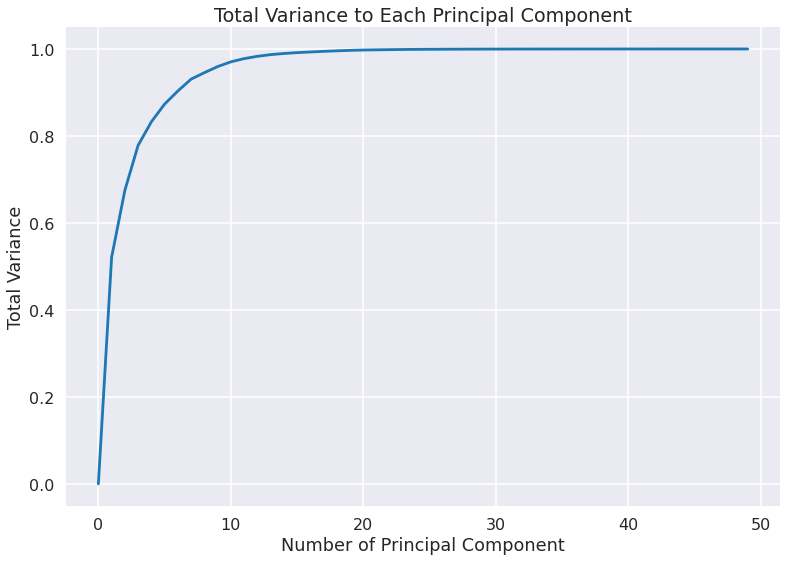

<Figure size 921.6x633.6 with 0 Axes>

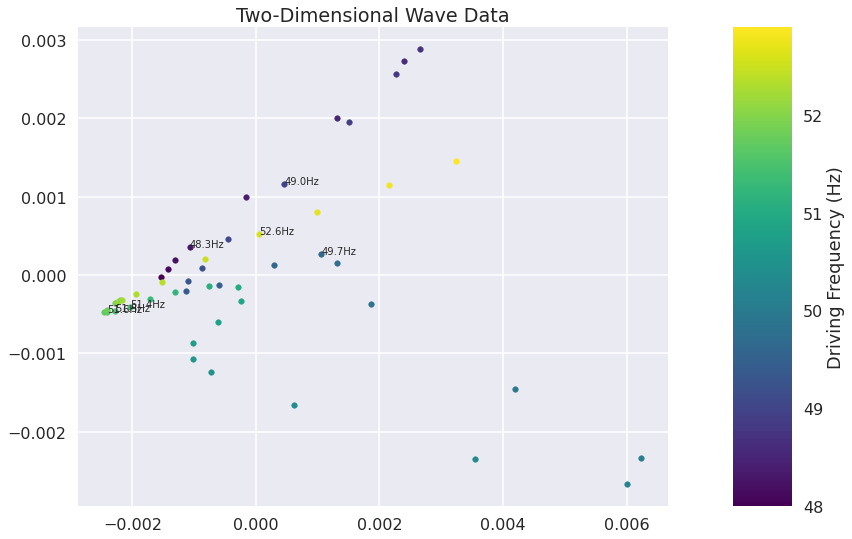

In [19]:
from sklearn.decomposition import PCA 
import matplotlib as m
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')

# reshape data arrays
X = np.array(patterns)
X = X.reshape(50, 2601)

# make array of labels
Y = np.round(freqs,1 )

# fit the data to receive eigenvectors of covariance matrix
skl_PCA = PCA(n_components = 50).fit(X) 

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# plot the variance ratio for each PC
variances = []
for i in range(len(skl_PCA.explained_variance_ratio_)):
    variances.append(sum(skl_PCA.explained_variance_ratio_[0:i]))
plt.plot(variances)
plt.title('Total Variance to Each Principal Component')
plt.xlabel('Number of Principal Component')
plt.ylabel('Total Variance')
plt.figure()


#fit the data with two PCs
skl_PCA = PCA(n_components = 2).fit(X)

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# set up colour bar
plt.viridis()
fig, [ax, cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]})
norm = m.colors.Normalize(min(Y), max(Y))
cb1 = m.colorbar.ColorbarBase(cax, norm=norm, orientation='vertical')

# plot and colour the data points according to the driving frequency
for i in range(len(Y)):
    mask = Y==Y[i]
    ax.scatter(skl_X_transformed[i,0], skl_X_transformed[i,1], marker = '.', c=Y[i], norm=norm)
    
ax.annotate('49.7Hz', (skl_X_transformed[17,0], skl_X_transformed[17,1]))
ax.annotate('51.4Hz', (skl_X_transformed[34,0], skl_X_transformed[34,1]))
ax.annotate('51.5Hz', (skl_X_transformed[35,0], skl_X_transformed[35,1]))
ax.annotate('51.6Hz', (skl_X_transformed[36,0], skl_X_transformed[36,1]))
ax.annotate('52.6Hz', (skl_X_transformed[46,0], skl_X_transformed[46,1]))
ax.annotate('48.3Hz', (skl_X_transformed[3,0], skl_X_transformed[3,1]))
ax.annotate('49.0Hz', (skl_X_transformed[10,0], skl_X_transformed[10,1]))
    
ax.set_title('Two-Dimensional Wave Data')
cax.set_ylabel('Driving Frequency (Hz)')

Dataset 1b, a plus-shaped room driven from the center at frequencies from 48Hz to 53Hz.

In [ ]:
# reshape data arrays
X = np.array(patterns2)
X = X.reshape(50, 2809)

# make array of labels
Y = np.round(freqs,1)

# fit the data to receive eigenvectors of covariance matrix
skl_PCA = PCA(n_components = 50).fit(X) 

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# plot the variance ratio for each PC
variances = []
for i in range(len(skl_PCA.explained_variance_ratio_)):
    variances.append(sum(skl_PCA.explained_variance_ratio_[0:i]))
plt.plot(variances)
plt.title('Total Variance to Each Principal Component')
plt.xlabel('Number of Principal Component')
plt.ylabel('Total Variance')
plt.figure()


#fit the data with two PCs
skl_PCA = PCA(n_components = 2).fit(X)

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# set up colour bar
plt.viridis()
fig, [ax, cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]})
norm = m.colors.Normalize(min(Y), max(Y))
cb1 = m.colorbar.ColorbarBase(cax, norm=norm, orientation='vertical')

# plot and colour the data points according to the driving frequency
for i in range(len(Y)):
    mask = Y==Y[i]
    ax.scatter(skl_X_transformed[i,0], skl_X_transformed[i,1], marker = '.', c=Y[i], norm=norm)

ax.annotate('52.3Hz', (skl_X_transformed[43,0], skl_X_transformed[43,1]))
ax.annotate('48.6Hz', (skl_X_transformed[6,0], skl_X_transformed[6,1]))
ax.annotate('48.1Hz', (skl_X_transformed[1,0], skl_X_transformed[1,1]))
ax.annotate('50.0Hz', (skl_X_transformed[20,0], skl_X_transformed[20,1]))
ax.set_title('Two-Dimensional Wave Data')
cax.set_ylabel('Driving Frequency (Hz)')

Next, dataset 2a, a square room driven at 50Hz from the middle left side, to the center of the room.

In [ ]:
# reshape data arrays
X = np.array(patterns3)
X.shape
X = X.reshape(21, 2601)

# make array of labels
Y = np.round(positions, 1)

# fit the data to receive eigenvectors of covariance matrix
skl_PCA = PCA(n_components = 21).fit(X) 

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# plot the variance ratio for each PC
variances = []
for i in range(len(skl_PCA.explained_variance_ratio_)):
    variances.append(sum(skl_PCA.explained_variance_ratio_[0:i]))
plt.plot(variances)
plt.title('Total Variance to Each Principal Component')
plt.xlabel('Number of Principal Component')
plt.ylabel('Total Variance')
plt.figure()


#fit the data with two PCs
skl_PCA = PCA(n_components = 2).fit(X)

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# set up colour bar
plt.viridis()
fig, [ax, cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]})
norm = m.colors.Normalize(min(Y), max(Y))
cb1 = m.colorbar.ColorbarBase(cax, norm=norm, orientation='vertical')

# plot and colour the data points according to the driving frequency
for i in range(len(Y)):
    mask = Y==Y[i]
    ax.scatter(skl_X_transformed[i,0], skl_X_transformed[i,1], marker = '.', c=Y[i], norm=norm)

for i, txt in enumerate(Y):
    ax.annotate(txt, (skl_X_transformed[i,0], skl_X_transformed[i,1]))
ax.set_title('Two-Dimensional Wave Data')
cax.set_ylabel('Driving Frequency (Hz)')

Finally, dataset 2b, a plus-shaped room driven at 50Hz, from the middle right wall to the center.

In [ ]:
# reshape data arrays
X = np.array(patterns4)
X = X.reshape(21, 2809)

# make array of labels
Y = np.round(positions,1)

# fit the data to receive eigenvectors of covariance matrix
skl_PCA = PCA(n_components = 21).fit(X) 

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# plot the variance ratio for each PC
variances = []
for i in range(len(skl_PCA.explained_variance_ratio_)):
    variances.append(sum(skl_PCA.explained_variance_ratio_[0:i]))
plt.plot(variances)
plt.title('Total Variance to Each Principal Component')
plt.xlabel('Number of Principal Component')
plt.ylabel('Total Variance')
plt.figure()


#fit the data with two PCs
skl_PCA = PCA(n_components = 2).fit(X)

# transform the data into the component basis
skl_X_transformed = skl_PCA.transform(X) 

# set up colour bar
plt.viridis()
fig, [ax, cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]})
norm = m.colors.Normalize(min(Y), max(Y))
cb1 = m.colorbar.ColorbarBase(cax, norm=norm, orientation='vertical')

# plot and colour the data points according to the driving frequency
for i in range(len(Y)):
    mask = Y==Y[i]
    ax.scatter(skl_X_transformed[i,0], skl_X_transformed[i,1], marker = '.', c=Y[i], norm=norm)


for i, txt in enumerate(Y):
    ax.annotate(txt, (skl_X_transformed[i,0]+0.0001, skl_X_transformed[i,1]))
    
ax.set_title('Two-Dimensional Wave Data')
cax.set_ylabel('Driving Position (m)')

### 2. Analysing the results with NMF
Using the data from the PCA analysis, we choose a pattern that is very similar to many others, as in one that is in a dense location on the 2D data plot, and find its Non-Negative Factorization. Then, using the component matrix obtained from that pattern, we apply NMF to each other sample using the component array from the first. Using these results, we can plot the reconstruction error of each pattern using this common component matrix, and then plot the reconstructions of the patterns with the largest error, and with the smallest. 

Dataset 1a. For this one, we're using the resonance pattern at 49.0Hz as the common pattern.

In [ ]:
from sklearn.decomposition import NMF, non_negative_factorization
X = np.array(patterns)
X_common = X[10]

Y = freqs

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')
# train NMF model to fit the model of one of the components
# with least impact on variance
skl_NMF = NMF().fit(X_common) 

# transform the data into the component basis
skl_X_transformed = skl_NMF.transform(X_common) 

# find the component matrix for a common X
H_common = skl_NMF.components_

# loop through all patterns and factor them with the component matrix
# H_common, and record the reconstruction error and weight matrices
Ws = []
Errors = []
for i in range(len(Y)):
    # factor the resonance pattern with the components of the NMF of 
    # the common pattern predefined
    W, H, n_iter = non_negative_factorization(X[i], update_H=False, H=H_common)
    Ws.append(W)
    
    # find Frobenius norm between reconstruction and original
    err = 0.5 * np.sum(np.power(X[i] - W*H, 2))
    Errors.append(err)

# plot the reconstruction errors for each pattern
plt.figure()
plt.scatter(Y, Errors)
plt.ylim(-0.00005, 1.3 * np.max(Errors))
plt.title('Reconstruction Error using Common Component Matrix')
plt.ylabel('Frobenius Norm of X and W*H')
plt.xlabel('Resonancy Frequency (Hz)')


# find the index of the images with most and least reconstruction error
i_min = Errors.index(min(Errors))
i_max = Errors.index(max(Errors))

# plot the weight matrix, reconstructed image, and original image for the
# patterns with lowest and highest reconstruction error
plt.figure()
plt.style.use('default')
plt.style.use('seaborn-poster')
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(Ws[i_min])
ax1.set_title('Weight Matrix\nSmallest Error')
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(Ws[i_min].dot(H_common))
ax2.set_title('Reconstructed\nSmallest Error')
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(X[i_min])
ax3.set_title('Original\nSmallest Error')
ax4 = plt.subplot(2, 3, 4)
ax4.imshow(Ws[i_max])
ax4.set_title('Largest Error')
ax5 = plt.subplot(2, 3, 5)
ax5.imshow(Ws[i_max].dot(H_common))
ax5.set_title('Largest Error')
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(X[i_max])
ax6.set_title('Largest Error')

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')

Dataset 1b. For this, we use the resonance pattern at 50.0Hz.

In [ ]:
X = np.array(patterns2)
X_common = X[20]

Y = freqs

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')
# train NMF model to fit the model of one of the components
# with least impact on variance
skl_NMF = NMF().fit(X_common) 

# transform the data into the component basis
skl_X_transformed = skl_NMF.transform(X_common) 

# find the component matrix for a common X
H_common = skl_NMF.components_

# loop through all patterns and factor them with the component matrix
# H_common, and record the reconstruction error and weight matrices
Ws = []
Errors = []
for i in range(len(Y)):
    # factor the resonance pattern with the components of the NMF of 
    # the common pattern predefined
    W, H, n_iter = non_negative_factorization(X[i], update_H=False, H=H_common)
    Ws.append(W)
    
    # find Frobenius norm between reconstruction and original
    err = 0.5 * np.sum(np.power(X[i] - W*H, 2))
    Errors.append(err)

# plot the reconstruction errors for each pattern
plt.figure()
plt.scatter(Y, Errors)
plt.ylim(-0.00005, 1.3 * np.max(Errors))
plt.title('Reconstruction Error using Common Component Matrix')
plt.ylabel('Frobenius Norm of X and W*H')
plt.xlabel('Resonancy Frequency (Hz)')


# find the index of the images with most and least reconstruction error
i_min = Errors.index(min(Errors))
i_max = Errors.index(max(Errors))

# plot the weight matrix, reconstructed image, and original image for the
# patterns with lowest and highest reconstruction error
plt.figure()
plt.style.use('default')
plt.style.use('seaborn-poster')
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(Ws[i_min])
ax1.set_title('Weight Matrix\nSmallest Error')
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(Ws[i_min].dot(H_common))
ax2.set_title('Reconstructed\nSmallest Error')
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(X[i_min])
ax3.set_title('Original\nSmallest Error')
ax4 = plt.subplot(2, 3, 4)
ax4.imshow(Ws[i_max])
ax4.set_title('Largest Error')
ax5 = plt.subplot(2, 3, 5)
ax5.imshow(Ws[i_max].dot(H_common))
ax5.set_title('Largest Error')
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(X[i_max])
ax6.set_title('Largest Error')

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')

Dataset 2a. Since there is no major clustering of points like in the first two datasets, I use the 18m datapoint since it is the datapoint closest to the origin.

In [ ]:
X = np.array(patterns3)
X_common = X[13]

Y = positions

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')
# train NMF model to fit the model of one of the components
# with least impact on variance
skl_NMF = NMF().fit(X_common) 

# transform the data into the component basis
skl_X_transformed = skl_NMF.transform(X_common) 

# find the component matrix for a common X
H_common = skl_NMF.components_

# loop through all patterns and factor them with the component matrix
# H_common, and record the reconstruction error and weight matrices
Ws = []
Errors = []
for i in range(len(Y)):
    # factor the resonance pattern with the components of the NMF of 
    # the common pattern predefined
    W, H, n_iter = non_negative_factorization(X[i], update_H=False, H=H_common)
    Ws.append(W)
    
    # find Frobenius norm between reconstruction and original
    err = 0.5 * np.sum(np.power(X[i] - W*H, 2))
    Errors.append(err)

# plot the reconstruction errors for each pattern
plt.figure()
plt.scatter(Y, Errors)
plt.ylim(0.5*np.min(Errors), 1.3 * np.max(Errors))
plt.title('Reconstruction Error using Common Component Matrix')
plt.ylabel('Frobenius Norm of X and W*H')
plt.xlabel('Driving Position (m)')


# find the index of the images with most and least reconstruction error
i_min = Errors.index(min(Errors))
i_max = Errors.index(max(Errors))

# plot the weight matrix, reconstructed image, and original image for the
# patterns with lowest and highest reconstruction error
plt.figure()
plt.style.use('default')
plt.style.use('seaborn-poster')
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(Ws[i_min])
ax1.set_title('Weight Matrix\nSmallest Error')
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(Ws[i_min].dot(H_common))
ax2.set_title('Reconstructed\nSmallest Error')
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(X[i_min])
ax3.set_title('Original\nSmallest Error')
ax4 = plt.subplot(2, 3, 4)
ax4.imshow(Ws[i_max])
ax4.set_title('Largest Error')
ax5 = plt.subplot(2, 3, 5)
ax5.imshow(Ws[i_max].dot(H_common))
ax5.set_title('Largest Error')
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(X[i_max])
ax6.set_title('Largest Error')

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')

Dataset 2b. Again, the points are quite spread out, but this time there is no point that is much closer to the origin than another, so I choose the 25m point, as is has at least more points clustering it than others.

In [ ]:
X = np.array(patterns4)
X_common = X[20]

Y = positions

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')
# train NMF model to fit the model of one of the components
# with least impact on variance
skl_NMF = NMF().fit(X_common) 

# transform the data into the component basis
skl_X_transformed = skl_NMF.transform(X_common) 

# find the component matrix for a common X
H_common = skl_NMF.components_

# loop through all patterns and factor them with the component matrix
# H_common, and record the reconstruction error and weight matrices
Ws = []
Errors = []
for i in range(len(Y)):
    # factor the resonance pattern with the components of the NMF of 
    # the common pattern predefined
    W, H, n_iter = non_negative_factorization(X[i], update_H=False, H=H_common)
    Ws.append(W)
    
    # find Frobenius norm between reconstruction and original
    err = 0.5 * np.sum(np.power(X[i] - W*H, 2))
    Errors.append(err)

# plot the reconstruction errors for each pattern
plt.figure()
plt.scatter(Y, Errors)
plt.ylim(-0.00001, 1.3 * np.max(Errors))
plt.title('Reconstruction Error using Common Component Matrix')
plt.ylabel('Frobenius Norm of X and W*H')
plt.xlabel('Driving Position (m)')


# find the index of the images with most and least reconstruction error
i_min = Errors.index(min(Errors))
i_max = Errors.index(max(Errors))

# plot the weight matrix, reconstructed image, and original image for the
# patterns with lowest and highest reconstruction error
plt.figure()
plt.style.use('default')
plt.style.use('seaborn-poster')
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(Ws[i_min])
ax1.set_title('Weight Matrix\nSmallest Error')
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(Ws[i_min].dot(H_common))
ax2.set_title('Reconstructed\nSmallest Error')
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(X[i_min])
ax3.set_title('Original\nSmallest Error')
ax4 = plt.subplot(2, 3, 4)
ax4.imshow(Ws[i_max])
ax4.set_title('Largest Error')
ax5 = plt.subplot(2, 3, 5)
ax5.imshow(Ws[i_max].dot(H_common))
ax5.set_title('Largest Error')
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(X[i_max])
ax6.set_title('Largest Error')

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')

## References
- Langtangen, H. P. (2016). _Finite difference methods for wave motion_. Retrieved from http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/pdf/wave-4print.pdf

Very helpful text touching on methods of finite difference analysis, with examples and python code. Used to learn the concepts of vectorization for the solver function, for reference theory on driven and damped waves, and for theory on the stability of finite difference methods.